In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import datetime
from scipy import stats
from scipy.stats import gaussian_kde, norm, cauchy

from scipy.stats import t

import matplotlib.pyplot as plt
import statsmodels.api as sm


from arch import arch_model

import statsmodels.formula.api as smf
import yfinance as yf

start="2021-01-01"
end="2023-05-04"
ticker = 'BTC-USD'
df = pd.DataFrame()
df[ticker] = yf.download(ticker, start="2016-01-01", end="2018-03-30")['Close']




log_ret = np.log(1 + df.pct_change())

log_ret.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
log_ret.dropna(inplace=True) 
  
log_returns=np.asarray(log_ret)

[*********************100%***********************]  1 of 1 completed


In [2]:

# w=window length (trading days)
#alpha = the significance level
w=250
alpha=0.01


VaR_empiric=[]
VaR_normal=[]
VaR_GARCH_n=[]
VaR_GARCH_t=[]
VaR_t=[]


#from numba import autojit
#@autojit
def Rolling_VaR(log_returns,w,alpha):
    iterations=len(log_returns)-w

    for i in range(1,iterations):
        ret=log_returns[i:(w+i-1)]
        q=np.quantile(ret, alpha)
   
        x=(ret[ret<=q])
        y=np.asarray(x)
        n=len(y)
        
        mu=ret.mean()
        sigma=ret.std()
        v_normal=norm.ppf(alpha)*sigma+mu;

        VaR_normal.append(v_normal);
        
        r = t.fit(ret)
        nu=r[0]
        v_t = (t.ppf(alpha, nu)*sigma)+mu
        VaR_t.append(v_t);
        '''
        if nu>2:
            v_t = -(np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu)*sigma - mu)
            VaR_t.append(v_t);
        else:
            v_t = -(t.ppf(1-alpha, nu)*sigma - mu)
            VaR_t.append(v_t);
        '''    
        v_empiric=np.quantile(ret,alpha);
        VaR_empiric.append(v_empiric);

        # define model with Normal residuals
        model = arch_model(ret*100, vol='GARCH', p=1, q=1);
        # fit model
        model_fit = model.fit(disp=0);
        # forecast the test set
        yhat = model_fit.forecast(horizon=1);
        var_n=(0.01*np.sqrt(yhat.variance.values[-1]) * norm.ppf(alpha) +mu)
        VaR_GARCH_n.append(var_n);

        # define model
        model = arch_model(ret*100, vol='GARCH', p=1, q=1,dist='StudentsT');
        # fit model
        model_fit = model.fit(disp=0);
        df=(model_fit.params[4]);
        # forecast the test set
        yhat = model_fit.forecast(horizon=1);
        var_t=(0.01*np.sqrt(yhat.variance.values[-1]) * t.ppf(alpha,df) +mu);
        VaR_GARCH_t.append(var_t);



In [3]:
%%capture
from timeit import default_timer as timer
start = timer()
Rolling_VaR(log_returns,w,alpha)
dt = timer() - start


In [4]:
print ("Created in %f s" % dt)

Created in 84.129312 s


In [5]:
df_new=log_ret[(w+1):len(log_ret)]
dates=df_new.index.tolist()


VaR_empiric=np.asarray(VaR_empiric)
VaR_normal=np.asarray(VaR_normal)
VaR_GARCH_n=np.asarray(VaR_GARCH_n)


VaR_GARCH_t=np.asarray(VaR_GARCH_t)


VaR_t=np.asarray(VaR_t)


returns=np.asarray(log_returns[(w+1):len(log_returns)])

len(returns)

567

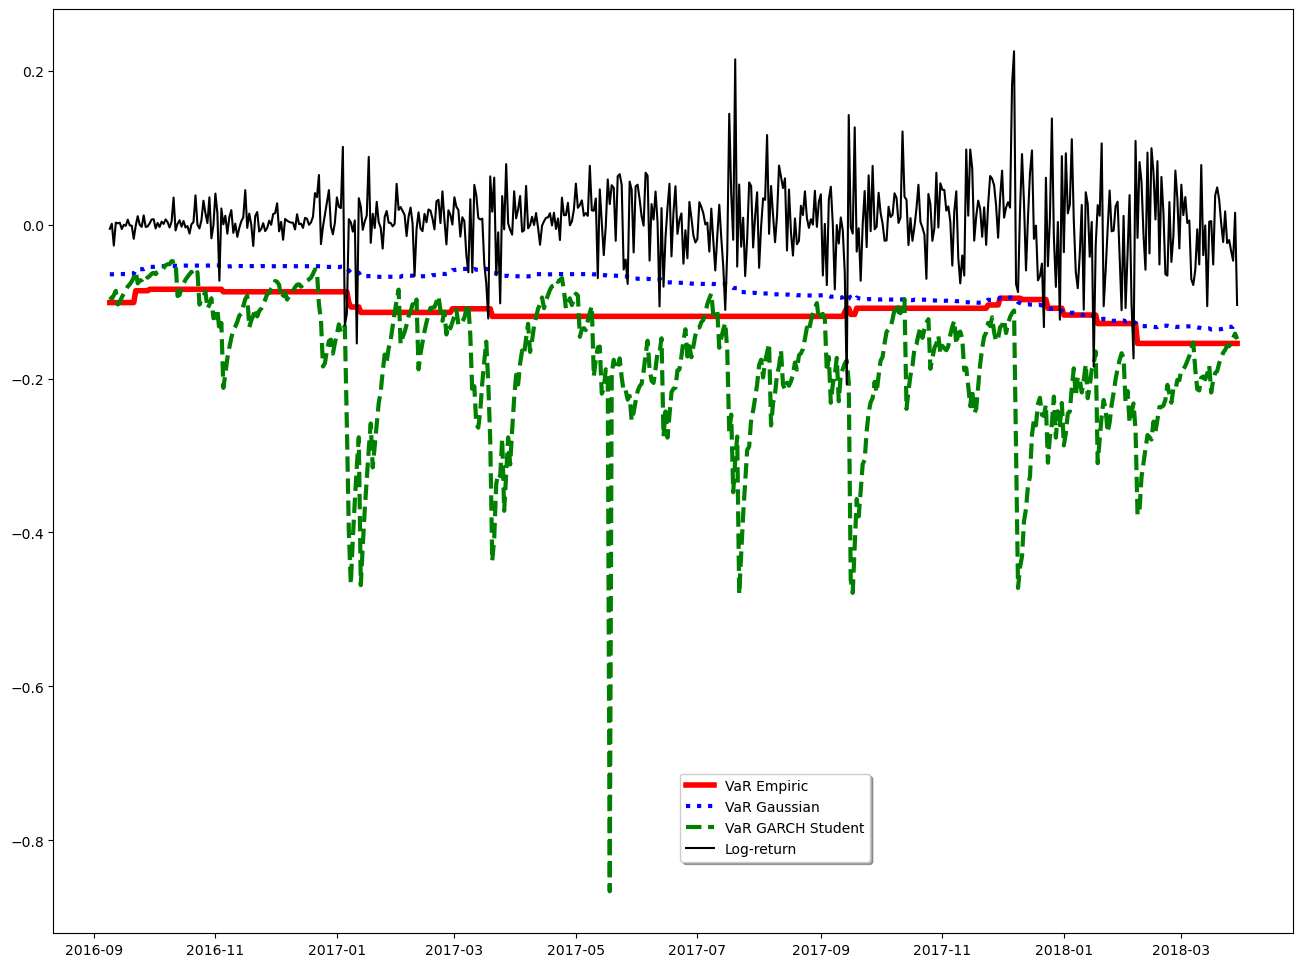

In [6]:
plt.figure( figsize=(16,12))
plt.plot(dates,VaR_empiric,label='VaR Empiric', c='red',linewidth=4)
#plt.plot(dates, VaR_GARCH_n, label='VaR GARCH Gaussian',c='blue')
plt.plot(dates,VaR_normal, label='VaR Gaussian',c='blue',linewidth=3,linestyle = 'dotted')
plt.plot(dates, VaR_GARCH_t, label='VaR GARCH Student',c='green',linestyle = 'dashed',linewidth=3)
#plt.plot(dates, VaR_t, label='VaR Student',c='brown')
plt.plot(dates, returns, label='Log-return',c='black')
#plt.plot(VaR_empiric, label='VaR')
#plt.plot(VaR_GARCH_n, label='VaR GARCH Gaussian')

plt.legend(loc='lower left',bbox_to_anchor=(0.5, 0.07), fancybox=True, shadow=True)
#plt.show()
#plt.savefig('chart.png', dpi=500)

In [7]:
#https://github.com/BayerSe/VaR-Backtesting/blob/master/backtest.py



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

plt.ioff()


class Backtest:
    def __init__(self, actual, forecast, alpha):
        self.index = actual.index
        self.actual = actual.values
        self.forecast = forecast.values
        self.alpha = alpha

    def hit_series(self):
        return (self.actual < self.forecast) * 1

    def number_of_hits(self):
        return self.hit_series().sum()

    def hit_rate(self):
        return self.hit_series().mean()

    def expected_hits(self):
        return self.actual.size * self.alpha

    def duration_series(self):
        hit_series = self.hit_series()
        hit_series[0] = 1
        hit_series[-1] = 1
        return np.diff(np.where(hit_series == 1))[0]
    
    def binomial_test(self):
        #Binomial Test
        N=len(self.actual)
  
        N_fail=self.hit_series().sum()
        z=(N_fail-N* self.alpha)/np.sqrt(N* self.alpha*(1- self.alpha))
        
        p_value = (1-norm.cdf(abs(z)))
        return pd.Series([z, p_value],
                         index=["Statistic", "p-value"], name="Binomial Test")
    
    def plot(self, file_name=None):
    
        # Re-add the time series index
        r = pd.Series(self.actual, index=self.index)
        q = pd.Series(self.forecast, index=self.index)

        sns.set_context("paper")
        sns.set_style("whitegrid", {"font.family": "serif", "font.serif": "Computer Modern Roman", "text.usetex": True})

        # Hits
        ax = r[r <= q].plot(color="red", marker="o", ls="None", figsize=(20, 10))
        for h in r[r <= q].index:
            plt.axvline(h, color="black", alpha=0.4, linewidth=1, zorder=0)

        # Positive returns
        r[q < r].plot(ax=ax, color="green", marker="o", ls="None")

        # Negative returns but no hit
        r[(q <= r) & (r <= 0)].plot(ax=ax, color="orange", marker="o", ls="None")

        # VaR
        q.plot(ax=ax, grid=False, color="black", rot=0)

        # Axes
        plt.xlabel("")
        plt.ylabel("Log Return")
        ax.yaxis.grid()

        sns.despine()
        if file_name is None:
            plt.show()
        else:
            plt.savefig(file_name, bbox_inches="tight")
        plt.close("all")

    def tick_loss(self, return_mean=True):
        loss = (self.alpha - self.hit_series()) * (self.actual - self.forecast)
        if return_mean:
            return loss.mean()
        else:
            return loss

    def smooth_loss(self, delta=25, return_mean=True):
        """Gonzalez-Rivera, Lee and Mishra (2004)"""
        loss = ((self.alpha - (1 + np.exp(delta*(self.actual - self.forecast)))**-1) * (self.actual - self.forecast))
        if return_mean:
            return loss.mean()
        else:
            return loss

    def quadratic_loss(self, return_mean=True):
        """Lopez (1999); Martens et al. (2009)"""
        loss = (self.hit_series() * (1 + (self.actual - self.forecast)**2))
        if return_mean:
            return loss.mean()
        else:
            return loss

    def firm_loss(self, c=1, return_mean=True):
        """Sarma et al. (2003)"""
        loss = (self.hit_series() * (1 + (self.actual - self.forecast)**2) - c*(1-self.hit_series()) * self.forecast)
        if return_mean:
            return loss.mean()
        else:
            return loss

    def lr_bt(self):
        """Likelihood ratio framework of Christoffersen (1998)"""
        hits = self.hit_series()   # Hit series
        tr = hits[1:] - hits[:-1]  # Sequence to find transitions

        # Transitions: nij denotes state i is followed by state j nij times
        n01, n10 = (tr == 1).sum(), (tr == -1).sum()
        n11, n00 = (hits[1:][tr == 0] == 1).sum(), (hits[1:][tr == 0] == 0).sum()

        # Times in the states
        n0, n1 = n01 + n00, n10 + n11
        n = n0 + n1

        # Probabilities of the transitions from one state to another
        p01, p11 = n01 / (n00 + n01), n11 / (n11 + n10)
        p = n1 / n

        if n1 > 0:
            # Unconditional Coverage
            uc_h0 = n0 * np.log(1 - self.alpha) + n1 * np.log(self.alpha)
            uc_h1 = n0 * np.log(1 - p) + n1 * np.log(p)
            uc = -2 * (uc_h0 - uc_h1)

            # Independence
            ind_h0 = (n00 + n01) * np.log(1 - p) + (n01 + n11) * np.log(p)
            ind_h1 = n00 * np.log(1 - p01) + n01 * np.log(p01) + n10 * np.log(1 - p11)
            if p11 > 0:
                ind_h1 += n11 * np.log(p11)
            ind = -2 * (ind_h0 - ind_h1)

            # Conditional coverage
            cc = uc + ind

            # Stack results
            df = pd.concat([pd.Series([uc, ind, cc]),
                            pd.Series([1 - stats.chi2.cdf(uc, 1),
                                       1 - stats.chi2.cdf(ind, 1),
                                       1 - stats.chi2.cdf(cc, 2)])], axis=1)
        else:
            df = pd.DataFrame(np.zeros((3, 2))).replace(0, np.nan)

        # Assign names
        df.columns = ["Statistic", "p-value"]
        df.index = ["Unconditional", "Independence", "Conditional"]

        return df

    def dq_bt(self, hit_lags=4, forecast_lags=1):
        """Dynamic Quantile Test (Engle & Manganelli, 2004)"""
        try:
            hits = self.hit_series()
            p, q, n = hit_lags, forecast_lags, hits.size
            pq = max(p, q - 1)
            y = hits[pq:] - self.alpha  # Dependent variable
            x = np.zeros((n - pq, 1 + p + q))
            x[:, 0] = 1  # Constant

            for i in range(p):  # Lagged hits
                x[:, 1 + i] = hits[pq-(i+1):-(i+1)]

            for j in range(q):  # Actual + lagged VaR forecast
                if j > 0:
                    x[:, 1 + p + j] = self.forecast[pq-j:-j]
                else:
                    x[:, 1 + p + j] = self.forecast[pq:]

            beta = np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T, y))
            lr_dq = np.dot(beta, np.dot(np.dot(x.T, x), beta)) / (self.alpha * (1-self.alpha))
            p_dq = 1 - stats.chi2.cdf(lr_dq, 1+p+q)

        except:
            lr_dq, p_dq = np.nan, np.nan

        return pd.Series([lr_dq, p_dq],
                         index=["Statistic", "p-value"], name="DQ")





In [8]:

returns=pd.DataFrame(returns)


VaR_empiric=pd.DataFrame(VaR_empiric)
VaR_GARCH_n=pd.DataFrame(VaR_GARCH_n)
VaR_GARCH_t=pd.DataFrame(VaR_GARCH_t)
VaR_GARCH_n=pd.DataFrame(VaR_GARCH_n)
VaR_normal=pd.DataFrame(VaR_normal)
VaR_t=pd.DataFrame(VaR_t)

date=pd.DataFrame(dates)
results=pd.concat([date, returns, 
                  VaR_empiric,VaR_GARCH_n, VaR_GARCH_t, VaR_normal,VaR_t], axis=1)
results.columns=['date','Return', 'VaR Empiric','VaR GARCH Normal', 'VaR GARCH Student', 'VaR Normal','VaR Student']
results.set_index('date',inplace=True)
results=results.dropna()

In [9]:
results

,Return,VaR Empiric,VaR GARCH Normal,VaR GARCH Student,VaR Normal,VaR Student
date,,,,,,
2016-09-09,-0.005532,-0.101356,-0.038130,-0.093731,-0.064610,-0.340037
2016-09-10,0.001040,-0.101356,-0.039189,-0.096390,-0.064538,-0.329953
2016-09-11,-0.027297,-0.101356,-0.037328,-0.091886,-0.064592,-0.327901
2016-09-12,0.002509,-0.101356,-0.035202,-0.086123,-0.064574,-0.330291
2016-09-13,0.001640,-0.101356,-0.041967,-0.103808,-0.064782,-0.329216
...,...,...,...,...,...,...
2018-03-25,-0.020082,-0.154418,-0.109565,-0.158076,-0.132672,-0.196998
2018-03-26,-0.034290,-0.154418,-0.108203,-0.153248,-0.132904,-0.197220
2018-03-27,-0.046929,-0.154418,-0.106585,-0.147028,-0.132907,-0.197205


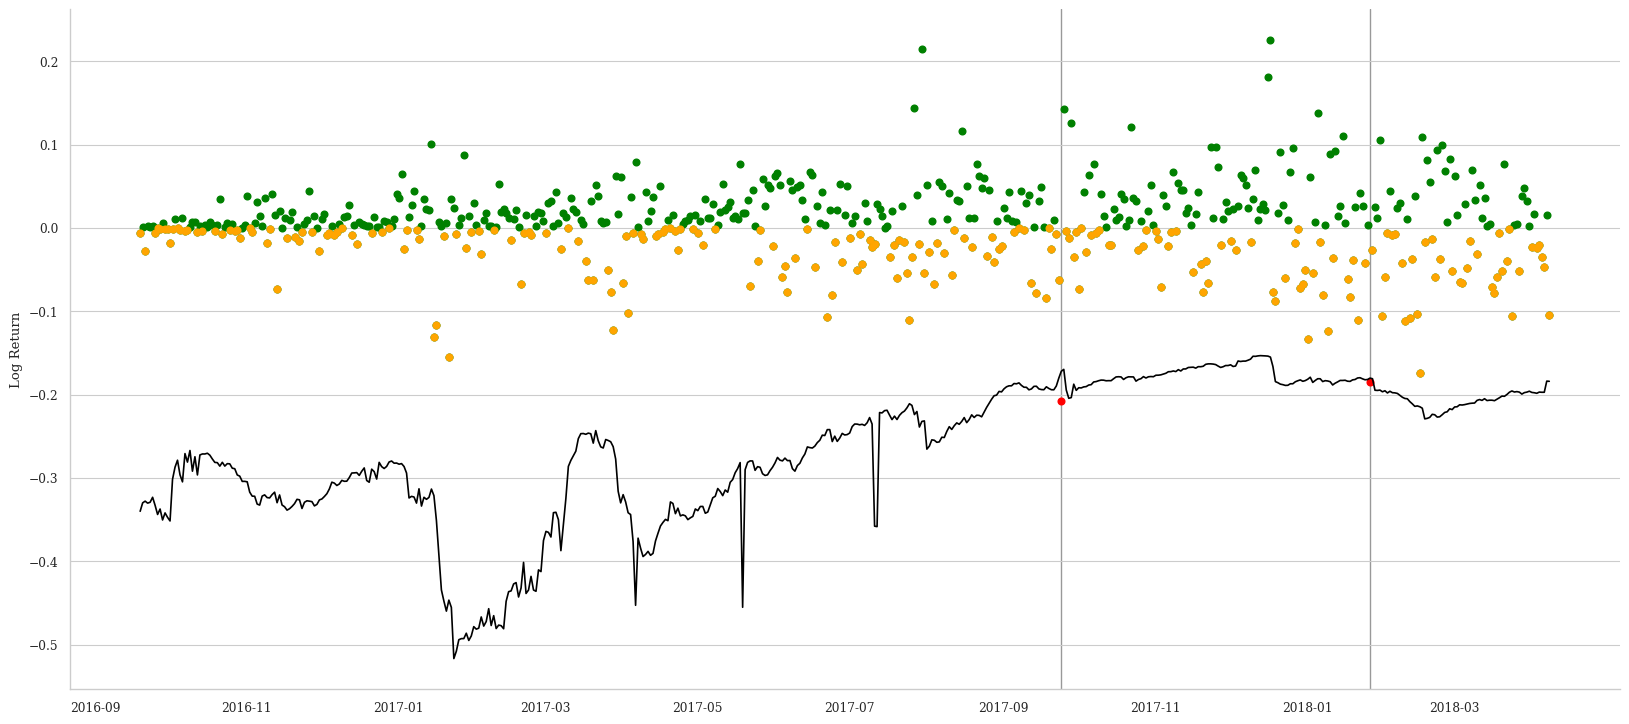

In [10]:
bt = Backtest(actual=results['Return'], forecast=results['VaR Student'], alpha=alpha)
bt.plot()

In [11]:
#Number of hits
   
bt.number_of_hits()



2

In [12]:
# Hit rate
bt.hit_rate()

0.003527336860670194

In [13]:
# Christophersen Test
cr=bt.lr_bt()
cr

,Statistic,p-value
Unconditional,3.182747,0.074419
Independence,0.014184,0.905197
Conditional,3.196932,0.202206


In [14]:
#Binomial test
print(bt.binomial_test())

Statistic   -1.549020
p-value      0.060688
Name: Binomial Test, dtype: float64


In [15]:
variants= ['VaR Empiric','VaR GARCH Normal', 'VaR GARCH Student', 'VaR Normal','VaR Student']
Binomial_test=[]
C_U=[]
C_I=[]
C_C=[]
rows=[]
hits=[]
h_rate=[]

for i in variants:
    bt = Backtest(actual=results['Return'], forecast=results[i], alpha=alpha)
    Binomial_test.append(bt.binomial_test())
    rows.append(i)
    h_rate.append(bt.hit_rate())
    hits.append(bt.number_of_hits())
    C_U.append(bt.lr_bt().iloc[[0]].reset_index(drop=True))
Binomial_test=pd.DataFrame(Binomial_test).reset_index()

In [16]:
Binomial_test

,index,Statistic,p-value
0,Binomial Test,1.405514,7.993428e-02
1,Binomial Test,4.782123,8.672655e-07
2,Binomial Test,-1.549020,6.068849e-02
3,Binomial Test,6.470428,4.886280e-11
4,Binomial Test,-1.549020,6.068849e-02


In [17]:
variants= ['VaR Empiric','VaR GARCH Normal', 'VaR GARCH Student', 'VaR Normal','VaR Student']
Binomial_test=[]
Christophersen_test=[]
rows=[]
hits=[]
h_rate=[]

for i in variants:
    bt = Backtest(actual=results['Return'], forecast=results[i], alpha=alpha)
    Binomial_test.append(bt.binomial_test())
    rows.append(i)
    h_rate.append(bt.hit_rate())
    hits.append(bt.number_of_hits())
    Christophersen_test.append(bt.lr_bt().reset_index(drop=True))
Binomial_test=pd.DataFrame(Binomial_test).reset_index()
rows=pd.DataFrame(rows)
rows['Number of observations']=len(results['Return'])
rows['alpha']=alpha
h_rate=pd.DataFrame(h_rate)
hits=pd.DataFrame(hits)
Binomial_test=pd.concat([rows, hits,h_rate, Binomial_test],  axis=1)
Binomial_test.columns=['Method','Number of observations','alpha',
                       'Number of failures', 'Failure Rate','Test', 'Statistic','p-value']
Binomial_test['Statistic']=round(Binomial_test['Statistic'], 3)
Binomial_test['p-value']=round(Binomial_test['p-value'], 3)
Binomial_test['Failure Rate']=round(Binomial_test['Failure Rate'], 3)
Binomial_test

,Method,Number of observations,alpha,Number of failures,Failure Rate,Test,Statistic,p-value
0,VaR Empiric,567,0.01,9,0.016,Binomial Test,1.406,0.080
1,VaR GARCH Normal,567,0.01,17,0.030,Binomial Test,4.782,0.000
2,VaR GARCH Student,567,0.01,2,0.004,Binomial Test,-1.549,0.061
3,VaR Normal,567,0.01,21,0.037,Binomial Test,6.470,0.000
4,VaR Student,567,0.01,2,0.004,Binomial Test,-1.549,0.061


We are using the one-sided Binomial test.

Thus, the hypothesis are the following:
$$H_{0}: p = \alpha$$
$$H_{A}: p \gt \alpha$$
where $p$ is the empirical probability of failure (failure rate).

The p-value is given by $P(Z>Z\_statistic)$, which we calculate with $norm.cdf(Z\_statistic)$.

If we reject $H_{0}$, then the probability of failures for a given model is higher than $\alpha$.


In [18]:
date=pd.DataFrame(dates)
results=pd.concat([date, returns, 
                  VaR_empiric,VaR_GARCH_n, VaR_GARCH_t, VaR_normal,VaR_t], axis=1)
results.columns=['date','Return', 'VaR_Empiric','VaR_GARCH_n', 'VaR_GARCH_t', 'VaR_normal','VaR_t']
results.set_index('date',inplace=True)

In [19]:
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare 
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion 
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power 
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than 
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):

    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = actual_lst.values.tolist()
    pred1_lst = pred1_lst.values.tolist()
    pred2_lst = pred2_lst.values.tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [20]:
rt = dm_test(results['Return'], 
             results['VaR_GARCH_t'],
              results['VaR_t'],h = 1, crit="MSE")
print (rt)


dm_return(DM=-12.595302511381648, p_value=3.0525700259707336e-32)


In [21]:
#Forecasting
ret=log_returns[-w:]

mu=ret.mean()
print(mu)
# define model
model = arch_model(ret*100, vol='GARCH', p=1, q=1,dist='StudentsT');
# fit model
model_fit = model.fit(disp=0);
df=(model_fit.params[4]);
print(model_fit.summary())
# forecast the test set
yhat = model_fit.forecast(horizon=1);
var_t=0.01*np.sqrt(yhat.variance.values[-1]) * t.ppf(alpha,df)  +mu;
yhat.variance.values[-1]

0.0037443142085656217
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -782.185
Distribution:      Standardized Student's t   AIC:                           1574.37
Method:                  Maximum Likelihood   BIC:                           1591.98
                                              No. Observations:                  250
Date:                      Sun, Jun 04 2023   Df Residuals:                      249
Time:                              10:38:00   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------------------

array([34.39219005])

In [22]:
#VaR pentru 14 Dec 2021
print(-var_t)

[0.18336142]


In [23]:
#VaR pentru 18 Dec 2021
var_t=0.01*np.sqrt(yhat.variance.values[-1]) *np.sqrt(4)* t.ppf(alpha,df)  +mu;
print(-var_t)

[0.37046716]


In [24]:
# VaR Normal pentru 14 Dec 2021

sigma=ret.std()
v_normal=norm.ppf(alpha, mu, sigma);
print(-v_normal)

0.131505809968343
